In [1]:
import re
import torch
import detector
import graphviz
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, tree, neighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from joblib import dump, load

LANGS = ['en', 'es', 'fr', 'de']
BLEU_HEURISTIC = {'de_en': 0.334, 'de_es': 0.305, 'de_fr': 0.312, 'en_de': 0.269, 'en_es': 0.389, 'en_fr': 0.370, 'es_de': 0.248, 'es_en': 0.395, 'es_fr': 0.354, 'fr_de': 0.237, 'fr_en': 0.356, 'fr_es': 0.337}
#BLEU_HEURISTIC = {'de_en': 0.222, 'de_es': 0.205, 'de_fr': 0.201, 'en_de': 0.170, 'en_es': 0.273, 'en_fr': 0.254, 'es_de': 0.158, 'es_en': 0.271, 'es_fr': 0.254, 'fr_de': 0.152, 'fr_en': 0.247, 'fr_es': 0.250}

In [2]:
data = pd.read_csv('data/bleu_table_back.csv', index_col=0)
data['src'] = data['src'].astype('category')
data['origin'] = data['origin'].astype('category')

In [3]:
data

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.830570,1.000000,0.847027,1.000000,0.0,0.0,0.753269,0.914226,fr,en,141.0
1,0.698240,0.979630,0.783569,0.908302,0.0,0.0,0.704352,0.822784,fr,en,137.0
2,0.793994,0.972784,0.832323,0.963932,0.0,0.0,0.707897,0.891895,fr,en,121.0
3,0.894837,0.969623,0.725450,0.842605,0.0,0.0,0.705540,0.873053,fr,en,117.0
4,0.828548,0.959342,0.758798,0.964595,0.0,0.0,0.750366,0.840804,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
29065,0.807270,0.912651,0.619860,0.806189,0.0,0.0,0.693823,0.804942,fr,de,121.0
29066,0.628562,0.905308,0.637654,0.951068,0.0,0.0,0.540897,0.922467,fr,de,135.0
29067,0.829006,0.941026,0.764103,0.979630,0.0,0.0,0.664335,0.733067,fr,de,133.0
29068,0.546226,0.928120,0.572617,0.926303,0.0,0.0,0.644991,0.888451,fr,de,138.0


## Utility functions

In [4]:
def plot_confusion_matrix(true_labels, prediction, column_labels): 
    cm_data = confusion_matrix(true_labels, prediction)
    df_cm = pd.DataFrame(cm_data, columns=column_labels, index=column_labels)
    df_cm.index.name = 'Valor Real'
    df_cm.columns.name = 'Predicción'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

def correct_by_lang_pair(table, pred, true):
    pred_data = table.copy()[['src']]
    pred_data['origin'] = true
    pred_data['src'] = pred_data['src'].apply(lambda x: int(x * 4) if x < 1 else int(x * 4) - 1)
    pred_data['pred'] = pred
    pred_data['right_pred'] = pred_data.apply(lambda x: x['origin'] == x['pred'], axis=1)
    correct = pred_data[pred_data['right_pred'] == True]
    correct = correct.groupby(['src', 'pred']).count()
    correct = correct[['right_pred']]
    correct['bleu'] = [BLEU_HEURISTIC["{}_{}".format(LANGS[x[0]], LANGS[x[1]])] for x in correct.index]
    # correct['bleu'] = normalize_values(correct['bleu'].values.reshape(-1, 1))
    return correct

def plot_correct_preds_by_lang_pair(correct_df):
    plot_labels = ["{}-{}".format(LANGS[idx[0]], LANGS[idx[1]]) for idx in correct.index]
    plot_df = pd.DataFrame(correct["right_pred"].values, index=plot_labels, columns=['Predicciones Correctas'])
    plt.figure(figsize = (10,7))
    plt.xlabel("Idioma Fuente - Idioma Original")
    sn.set(font_scale=1.4)
    sn.barplot(x=plot_labels, y=plot_df["Predicciones Correctas"], palette="Spectral")


## Filter problematic rows and columns

In [5]:
def non_equal_row(row):
    non_src_langs = [lang for lang in LANGS if lang != row['src']]
    unique_values = set([row['T0-T1_'+lang] for lang in non_src_langs] + [row['T1-T2_'+lang] for lang in non_src_langs])
    return len(unique_values) > 1

filtered = data[(data.len > 10) & (data.apply(non_equal_row, axis=1))]
filtered = filtered.reset_index(drop=True)
# filtered = filtered.drop(columns=['T2-T3_en', 'T2-T3_es', 'T2-T3_fr', 'T2-T3_de'])

In [6]:
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.830570,1.000000,0.847027,1.000000,0.0,0.0,0.753269,0.914226,fr,en,141.0
1,0.698240,0.979630,0.783569,0.908302,0.0,0.0,0.704352,0.822784,fr,en,137.0
2,0.793994,0.972784,0.832323,0.963932,0.0,0.0,0.707897,0.891895,fr,en,121.0
3,0.894837,0.969623,0.725450,0.842605,0.0,0.0,0.705540,0.873053,fr,en,117.0
4,0.828548,0.959342,0.758798,0.964595,0.0,0.0,0.750366,0.840804,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
29065,0.807270,0.912651,0.619860,0.806189,0.0,0.0,0.693823,0.804942,fr,de,121.0
29066,0.628562,0.905308,0.637654,0.951068,0.0,0.0,0.540897,0.922467,fr,de,135.0
29067,0.829006,0.941026,0.764103,0.979630,0.0,0.0,0.664335,0.733067,fr,de,133.0
29068,0.546226,0.928120,0.572617,0.926303,0.0,0.0,0.644991,0.888451,fr,de,138.0


## Remove divergent rows

In [7]:
convergent = []
for lang in LANGS:
    convergent.append(filtered[(filtered['T0-T1_{}'.format(lang)] <= filtered['T1-T2_{}'.format(lang)]) & (filtered['origin'] == lang)])

filtered = pd.concat(convergent, axis=0)
filtered = filtered.reset_index(drop=True)
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.830570,1.000000,0.847027,1.000000,0.0,0.0,0.753269,0.914226,fr,en,141.0
1,0.698240,0.979630,0.783569,0.908302,0.0,0.0,0.704352,0.822784,fr,en,137.0
2,0.793994,0.972784,0.832323,0.963932,0.0,0.0,0.707897,0.891895,fr,en,121.0
3,0.894837,0.969623,0.725450,0.842605,0.0,0.0,0.705540,0.873053,fr,en,117.0
4,0.828548,0.959342,0.758798,0.964595,0.0,0.0,0.750366,0.840804,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
28361,0.807270,0.912651,0.619860,0.806189,0.0,0.0,0.693823,0.804942,fr,de,121.0
28362,0.628562,0.905308,0.637654,0.951068,0.0,0.0,0.540897,0.922467,fr,de,135.0
28363,0.829006,0.941026,0.764103,0.979630,0.0,0.0,0.664335,0.733067,fr,de,133.0
28364,0.546226,0.928120,0.572617,0.926303,0.0,0.0,0.644991,0.888451,fr,de,138.0


## Add BLEU weight

In [8]:
std = StandardScaler()
std_vals = std.fit_transform(np.array(list(BLEU_HEURISTIC.values())).reshape(-1, 1))
DEVIATIONS = {key: std_vals[idx][0] for idx, key in enumerate(BLEU_HEURISTIC)}
DEVIATIONS


{'de_en': 0.16881402703068074,
 'de_es': -0.4071397122504653,
 'de_fr': -0.26811639587225766,
 'en_de': -1.1221167679098178,
 'en_es': 1.2611400842880256,
 'en_fr': 0.8837910826900334,
 'es_de': -1.5391867170444409,
 'es_en': 1.380302926897918,
 'es_fr': 0.5660235023969873,
 'fr_de': -1.75765192849591,
 'fr_en': 0.605744449933618,
 'fr_es': 0.2283954483356269}

In [9]:
def weight_score(row, factor = -0.02):
    src = row['src']
    for lang in LANGS:
        if lang != src:
            row['T0-T1_{}'.format(lang)] += DEVIATIONS["{}_{}".format(src, lang)] * factor
            row['T1-T2_{}'.format(lang)] += DEVIATIONS["{}_{}".format(src, lang)] * factor
    return row

weighted = filtered.copy()
weighted = weighted.apply(lambda x: weight_score(x, 0), axis=1)
weighted


,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.830570,1.000000,0.847027,1.000000,0.0,0.0,0.753269,0.914226,fr,en,141.0
1,0.698240,0.979630,0.783569,0.908302,0.0,0.0,0.704352,0.822784,fr,en,137.0
2,0.793994,0.972784,0.832323,0.963932,0.0,0.0,0.707897,0.891895,fr,en,121.0
3,0.894837,0.969623,0.725450,0.842605,0.0,0.0,0.705540,0.873053,fr,en,117.0
4,0.828548,0.959342,0.758798,0.964595,0.0,0.0,0.750366,0.840804,fr,en,121.0
...,...,...,...,...,...,...,...,...,...,...,...
28361,0.807270,0.912651,0.619860,0.806189,0.0,0.0,0.693823,0.804942,fr,de,121.0
28362,0.628562,0.905308,0.637654,0.951068,0.0,0.0,0.540897,0.922467,fr,de,135.0
28363,0.829006,0.941026,0.764103,0.979630,0.0,0.0,0.664335,0.733067,fr,de,133.0
28364,0.546226,0.928120,0.572617,0.926303,0.0,0.0,0.644991,0.888451,fr,de,138.0


## Generate Diffs Table

In [10]:
diffs = []
for lang in LANGS:
    first_col = 'T0-T1_{}'.format(lang)
    second_col = 'T1-T2_{}'.format(lang)
    diffs.append(weighted[[first_col, second_col, 'src']].apply(lambda x: ((1 - x[second_col]) + (1 - x[first_col])), axis=1))

diff_df = pd.concat(diffs + [weighted[['origin', 'src', 'len']]], axis=1)
diff_df.columns = ['en_diff', 'es_diff', 'fr_diff', 'de_diff','origin', 'src', 'len']

In [11]:
diff_df

,en_diff,es_diff,fr_diff,de_diff,origin,src,len
0,0.169430,0.152973,2.0,0.332505,en,fr,141.0
1,0.322130,0.308129,2.0,0.472864,en,fr,137.0
2,0.233221,0.203745,2.0,0.400209,en,fr,121.0
3,0.135541,0.431945,2.0,0.421406,en,fr,117.0
4,0.212109,0.276608,2.0,0.408830,en,fr,121.0
...,...,...,...,...,...,...,...
28361,0.280080,0.573951,2.0,0.501235,de,fr,121.0
28362,0.466129,0.411278,2.0,0.536636,de,fr,135.0
28363,0.229968,0.256267,2.0,0.602599,de,fr,133.0
28364,0.525653,0.501080,2.0,0.466558,de,fr,138.0


## A little bit of exploration

In [12]:
diff_ratios = []
for lang in LANGS:
    lang_col = '{}_diff'.format(lang)
    other_langs = ['{}_diff'.format(l) for l in LANGS if l != lang]
    diff_ratios.append(len(diff_df[(diff_df[lang_col] < diff_df[other_langs[0]]) & (diff_df[lang_col] < diff_df[other_langs[1]]) & (diff_df[lang_col] < diff_df[other_langs[2]]) & (diff_df['origin'] == lang)]) / len(diff_df[(diff_df['origin'] == lang)]))

diff_ratios

[0.7019636363636363,
 0.6043215939385436,
 0.41191676360346385,
 0.16417685227101253]

In [13]:
def convergence_ratio(df, l_cols, r_cols, origins):
    for lcol, rcol, orig in zip(l_cols, r_cols, origins):
        ratio = len(df[(df[lcol] <= df[rcol]) & (df['origin'] == orig)]) / len(df[(df['origin'] == orig)])
        print("Ratio for {} < {} and origin {}: {}".format(lcol, rcol, orig, ratio))

In [14]:
convergence_ratio(filtered, ['T0-T1_' + lang for lang in LANGS], ['T1-T2_' + lang for lang in LANGS], LANGS)

Ratio for T0-T1_en < T1-T2_en and origin en: 1.0
Ratio for T0-T1_es < T1-T2_es and origin es: 1.0
Ratio for T0-T1_fr < T1-T2_fr and origin fr: 1.0
Ratio for T0-T1_de < T1-T2_de and origin de: 1.0


## Normalize Data

In [15]:
def normalize_values(values, model_name=""):
    scaler = MinMaxScaler()
    scaler.fit(values)
    if model_name != "":
        dump(scaler, model_name)
    return scaler.transform(values)

norm_data = weighted.copy()

norm_data['len'] = normalize_values(norm_data['len'].values.reshape(-1, 1), "models/len_norm.joblib")
norm_data['src'] = normalize_values(np.array(norm_data['src'].apply(lambda x: LANGS.index(x)).values).reshape(-1, 1), "models/src_norm.joblib")
norm_data['origin'] = np.array(norm_data['origin'].apply(lambda x: LANGS.index(x)).values)

norm_data

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.830570,1.000000,0.847027,1.000000,0.0,0.0,0.753269,0.914226,0.666667,0,0.573991
1,0.698240,0.979630,0.783569,0.908302,0.0,0.0,0.704352,0.822784,0.666667,0,0.556054
2,0.793994,0.972784,0.832323,0.963932,0.0,0.0,0.707897,0.891895,0.666667,0,0.484305
3,0.894837,0.969623,0.725450,0.842605,0.0,0.0,0.705540,0.873053,0.666667,0,0.466368
4,0.828548,0.959342,0.758798,0.964595,0.0,0.0,0.750366,0.840804,0.666667,0,0.484305
...,...,...,...,...,...,...,...,...,...,...,...
28361,0.807270,0.912651,0.619860,0.806189,0.0,0.0,0.693823,0.804942,0.666667,3,0.484305
28362,0.628562,0.905308,0.637654,0.951068,0.0,0.0,0.540897,0.922467,0.666667,3,0.547085
28363,0.829006,0.941026,0.764103,0.979630,0.0,0.0,0.664335,0.733067,0.666667,3,0.538117
28364,0.546226,0.928120,0.572617,0.926303,0.0,0.0,0.644991,0.888451,0.666667,3,0.560538


## Training: Neural Network

In [51]:
dummy_y = [0] * len(norm_data.index)
X_train, X_test, y_train, y_test = train_test_split(norm_data, dummy_y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
6646,0.665151,0.760340,0.460163,0.753907,0.634412,0.872315,0.000000,0.000000,1.000000,0,0.538117
12058,0.656627,1.000000,0.731378,0.897641,0.000000,0.000000,0.426056,0.855030,0.666667,1,0.479821
23619,0.842296,1.000000,0.000000,0.000000,0.792474,0.849137,0.655499,0.890452,0.333333,3,0.408072
19828,0.648969,0.942279,0.000000,0.000000,0.732326,0.911671,0.615291,0.884695,0.333333,2,0.381166
16047,0.000000,0.000000,0.666220,0.954671,0.726156,0.901232,0.714490,0.924616,0.000000,2,0.331839
...,...,...,...,...,...,...,...,...,...,...,...
21575,0.735070,0.889178,0.000000,0.000000,0.791153,0.841495,0.633888,0.932418,0.333333,2,0.448430
5390,0.792853,0.863493,0.717002,0.976793,0.613541,0.780470,0.000000,0.000000,1.000000,0,0.461883
860,0.706135,0.898104,0.680473,0.881465,0.000000,0.000000,0.592938,0.955536,0.666667,0,0.484305
15795,0.000000,0.000000,0.674815,1.000000,0.787388,1.000000,0.667141,0.962043,0.000000,2,0.376682


In [ ]:
dataset = detector.BLEUDataset(X_train)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier_3k_v3_4000.pth'))
network.float()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
network.to(device)

In [ ]:
detector.train_classifier(network, loader, 2000, 20, device)

In [ ]:
torch.save(network.state_dict(), 'models/classifier_3k_v3_4000.pth')

## Testing the NN

In [52]:
dataset = detector.BLEUDataset(X_test)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier_3k_v3_4000.pth'))
network.float()

Classifier(
  (hidden0): Linear(in_features=10, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=4, bias=True)
  (l_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [53]:
pred = detector.test_classifier(network, loader)

Accuracy of the network on the test data: 58.21%


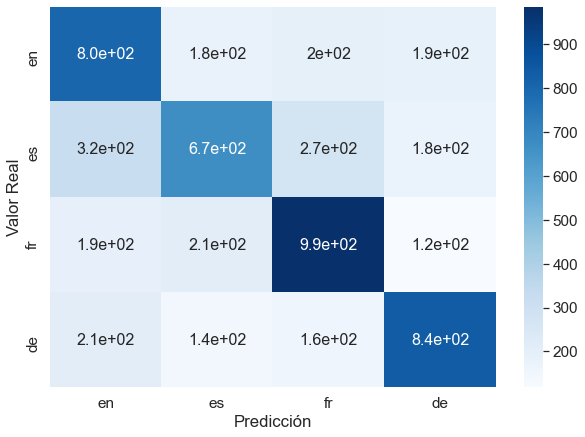

In [54]:
plot_confusion_matrix(dataset.get_all_labels(), pred, LANGS)

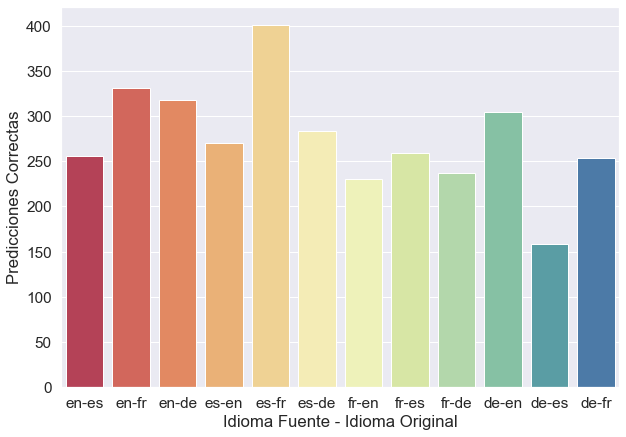

In [55]:
correct = correct_by_lang_pair(X_test, pred, X_test['origin'])
plot_correct_preds_by_lang_pair(correct)

## Training: Support Vector Machine

In [16]:
y = norm_data['origin']
X = norm_data.loc[:, norm_data.columns != 'origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,len
6646,0.665151,0.760340,0.460163,0.753907,0.634412,0.872315,0.000000,0.000000,1.000000,0.538117
12058,0.656627,1.000000,0.731378,0.897641,0.000000,0.000000,0.426056,0.855030,0.666667,0.479821
23619,0.842296,1.000000,0.000000,0.000000,0.792474,0.849137,0.655499,0.890452,0.333333,0.408072
19828,0.648969,0.942279,0.000000,0.000000,0.732326,0.911671,0.615291,0.884695,0.333333,0.381166
16047,0.000000,0.000000,0.666220,0.954671,0.726156,0.901232,0.714490,0.924616,0.000000,0.331839
...,...,...,...,...,...,...,...,...,...,...
21575,0.735070,0.889178,0.000000,0.000000,0.791153,0.841495,0.633888,0.932418,0.333333,0.448430
5390,0.792853,0.863493,0.717002,0.976793,0.613541,0.780470,0.000000,0.000000,1.000000,0.461883
860,0.706135,0.898104,0.680473,0.881465,0.000000,0.000000,0.592938,0.955536,0.666667,0.484305
15795,0.000000,0.000000,0.674815,1.000000,0.787388,1.000000,0.667141,0.962043,0.000000,0.376682


In [17]:
classifier = svm.SVC(probability=True, kernel='poly', C=2.0, gamma='scale')
classifier.fit(X_train, y_train)

SVC(C=2.0, kernel='poly', probability=True)

In [18]:
classifier.score(X_test, y_test)

0.5851251321818822

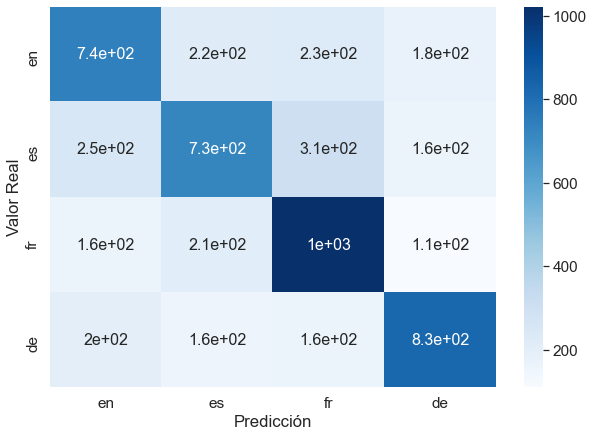

In [19]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, LANGS)

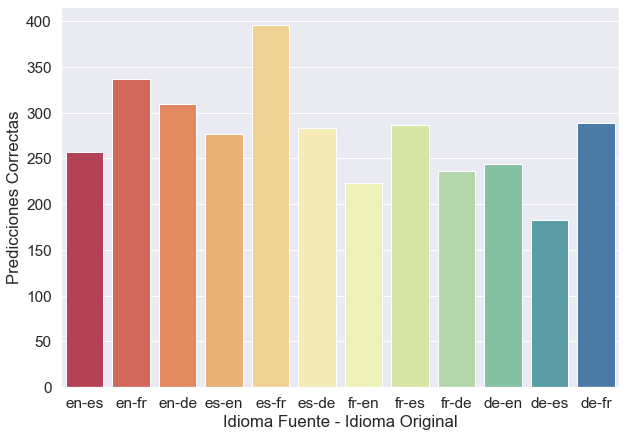

In [20]:
correct = correct_by_lang_pair(X_test, pred, y_test)
plot_correct_preds_by_lang_pair(correct)

In [21]:
dump(classifier, "models/svm.joblib")

['models/svm.joblib']

## Training: Decision Tree

In [22]:
classifier = tree.DecisionTreeClassifier(criterion='gini')
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
classifier.score(X_test, y_test)

0.47021501586182585

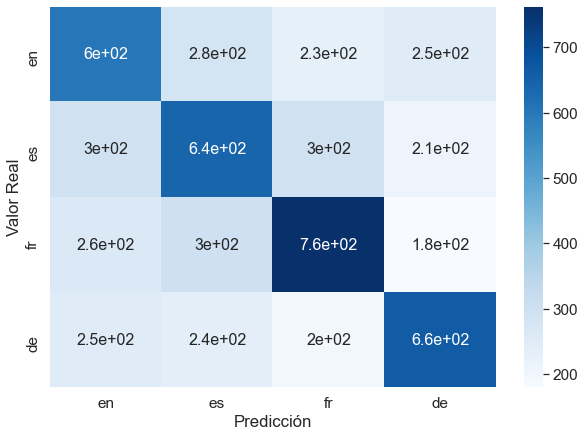

In [24]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, LANGS)

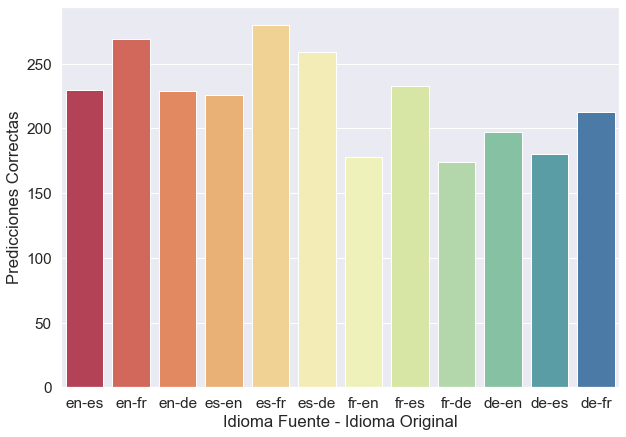

In [25]:
correct = correct_by_lang_pair(X_test, pred, y_test)
plot_correct_preds_by_lang_pair(correct)

In [65]:
#dot_data = tree.export_graphviz(classifier, out_file=None)
#graph = graphviz.Source(dot_data)
#graph.render("Tree")

In [26]:
dump(classifier, "models/dt.joblib")

['models/dt.joblib']

## Training: KNN

In [27]:
classifier = neighbors.KNeighborsClassifier(n_neighbors=141)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=141)

In [28]:
classifier.score(X_test, y_test)

0.5789566443426154

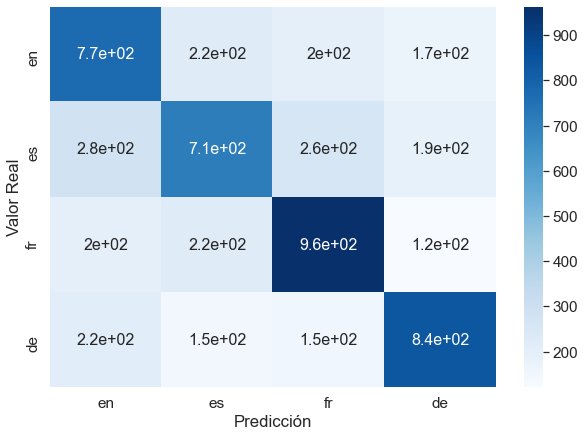

In [29]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, LANGS)

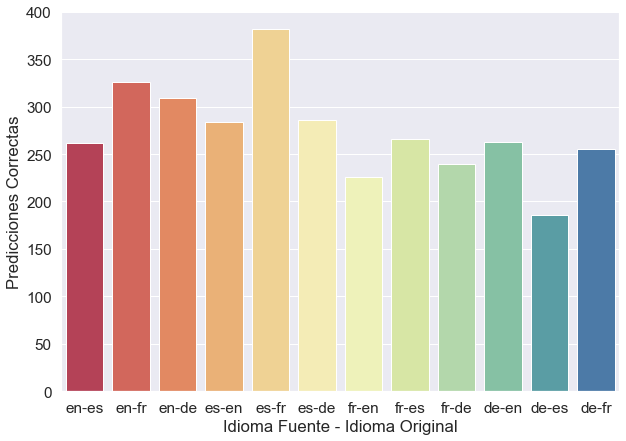

In [30]:
correct = correct_by_lang_pair(X_test, pred, y_test)
plot_correct_preds_by_lang_pair(correct)


In [32]:
dump(classifier, "models/knn.joblib")

['models/knn.joblib']